In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

mnist_train_path = 'train.csv'
mnist_test_path = 'test.csv'

mnist_train_df = pd.read_csv(mnist_train_path, header=None).T
mnist_test_df = pd.read_csv(mnist_test_path, header=None).T
last_column = mnist_test_df.columns[-1]
mnist_train_df.rename(columns={last_column:'Class'}, inplace=True)
mnist_test_df.rename(columns={last_column:'Class'}, inplace=True)

In [4]:
index_0s = mnist_train_df['Class'] == 0
index_1s = mnist_train_df['Class'] == 1
index_3s = mnist_train_df['Class'] == 3
index_5s = mnist_train_df['Class'] == 5

mnist_train_0_1_df = mnist_train_df.loc[index_0s | index_1s]
mnist_train_3_5_df = mnist_train_df.loc[index_3s | index_5s]

In [5]:
index_0s = mnist_test_df['Class'] == 0
index_1s = mnist_test_df['Class'] == 1
index_3s = mnist_test_df['Class'] == 3
index_5s = mnist_test_df['Class'] == 5

mnist_test_0_1_df = mnist_test_df.loc[index_0s | index_1s]
mnist_test_3_5_df = mnist_test_df.loc[index_3s | index_5s]

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

X_0_1 = mnist_train_0_1_df.drop('Class',axis=1)
X_3_5 = mnist_train_3_5_df.drop('Class',axis=1)

y_0_1 = mnist_train_0_1_df['Class']
y_3_5 = mnist_train_3_5_df['Class']

In [7]:
X_0_1t = mnist_test_0_1_df.drop('Class',axis=1)
X_3_5t = mnist_test_3_5_df.drop('Class',axis=1)

y_0_1t = mnist_test_0_1_df['Class']
y_3_5t = mnist_test_3_5_df['Class']

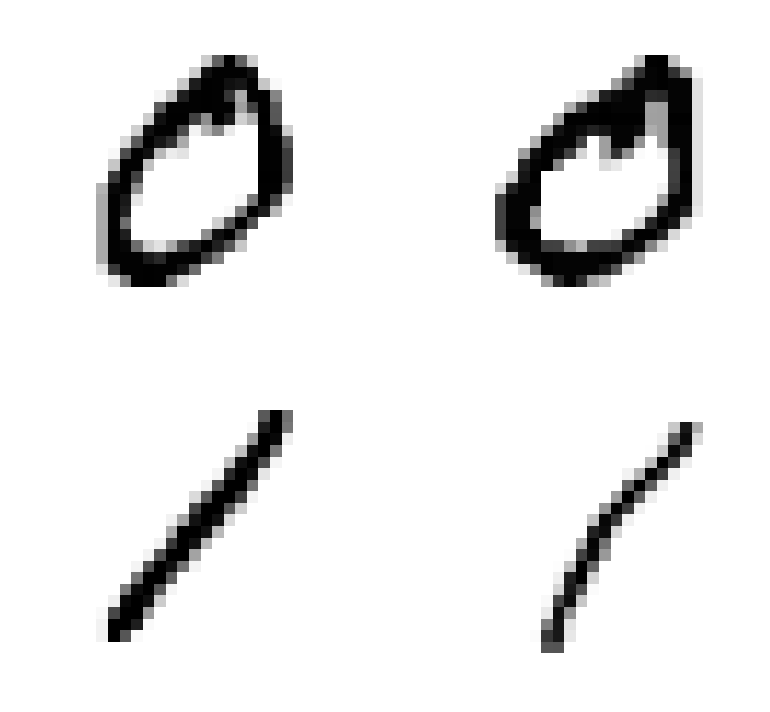

In [8]:
plt.figure(figsize=(12,10))
numbers = [0,1,12663,12664]
for i in range(4):
    example = X_0_1.ix[numbers[i]].reshape(28, 28).T
    plt.subplot(2, 2, i+1)
    plt.imshow(example, cmap='gray_r', interpolation='nearest')
    plt.axis("off")
plt.tight_layout()

In [9]:
X_3_5.shape

(11552, 784)

In [10]:
#X_std = pd.DataFrame(StandardScaler().fit_transform(X_0_1), columns=names[1:])
# my PCA
# part 0 standarize
from sklearn.preprocessing import StandardScaler
#X_std = StandardScaler().fit_transform(X_0_1)

# part 1
X_np = X_3_5
X_mu = np.mean(X_np, axis = 0)
X_sigma = np.cov(X_np.T)

print X_sigma.shape

(784, 784)


In [11]:
import numpy.linalg as LA
#eig_vec, eig_val, V = LA.svd(X_sigma)
eig_val, eig_vec = LA.eig(X_sigma)
pairs = [[np.abs(eig_val[i].real), eig_vec[:, i].real] for i in range(len(eig_val))]
pairs = sorted(pairs, key = lambda row : row[0], reverse = True)

    #print('eigenvalues:', [row[1] for row in pairs])

    # part 3 construct projection matrix W (to dimension k)
    # recover all the eig_vecs
eig_vecs_sorted = [row[1] for row in pairs]

In [12]:
eig_val.shape

(784,)

In [13]:
for i in range(10):
    print pairs[i][0]

5.90088905128
4.08049774264
3.4972783543
2.66403012737
2.16594445613
1.86061169698
1.50353679852
1.3371070646
1.25597068887
1.15401945399


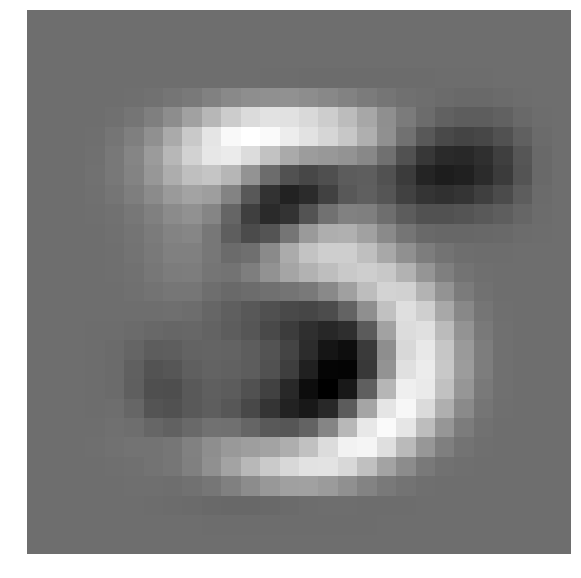

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(eig_vecs_sorted[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.axis("off")
plt.show()

In [15]:
# set the training set before the training!!!
X_train = X_3_5
y_train = y_3_5
X_test = X_3_5t
y_test = y_3_5t

# the list of Classes
Cs = [3, 5]

#labels name
labels = ['Class 3', 'Class 5']

In [16]:
# My LDA
# problem: 
# 1. compute d-dimensional mean vector for the different classes
# 2. Compute the scatter matrices (in-between-class and within-class)
# 3. Compute eigencector and eigenvalues for the scatter matrices
# 4. Sort by eigenvalues, choose k eigenvectors form W
# 5.  
# Do not use X_std
# Part 0 nomalize first
#def MyLDA(X, Cs)

# parameters:
# input X
X = X_train
y = y_train

# the number of dimension remain
k = 20

# Part 1 compuate mean
num_class = len(Cs)
di = X.shape[1]
X_means = []
X_cls = []

for i in Cs:
    tempi = X[y == i].as_matrix()
    X_cls.append(tempi)
    X_means.append(np.mean(tempi, axis = 0))

# Part 2 compute Scatter Matrix Sw
Sw = np.zeros([di,di])
for i in range(0, num_class):
    Sw += (len(X_cls[i])-1)*np.cov(X_cls[i].T)

mean_all = np.mean(X, axis = 0)
mean_all = mean_all.reshape(di,1)

Sb = np.zeros((di, di))
for i in range(0, num_class):
    meani = X_means[i]
    meani = meani.reshape(di, 1)
    Sb += len(X_cls[i]) * (meani - mean_all).dot((meani - mean_all).T)

Sb.shape

# add small value to the diagonal to make in non singular
Sw2 = Sw + np.eye(784) * 1e-06

In [17]:
# part solving eigenvec and eigenval for Sw^-1 Sb
eig_val, eig_vec = LA.eig(LA.inv(Sw2).dot(Sb))
eig_val = eig_val.real
eig_vec = eig_vec.real

# check the correction
#for i in range(len(eig_val)):
 #   v = eig_vec[:, i].reshape(di, 1)
  #  np.testing.assert_array_almost_equal(LA.inv(Sw).dot(Sb).dot(v),
   #                                     eig_val[i] * v, decimal = 6
    #                                   ,err_msg = '', verbose=True)

# Part 4 rank and select
pairs = [[eig_val[i], eig_vec[:, i]] for i in range(len(eig_val))]
pairs = sorted(pairs, key = lambda row : row[0], reverse = True)


# recover all the eig_vecs
eig_vecs_sorted = [row[1] for row in pairs]
W = eig_vecs_sorted[0:k]
W = np.matrix(W)
W = W

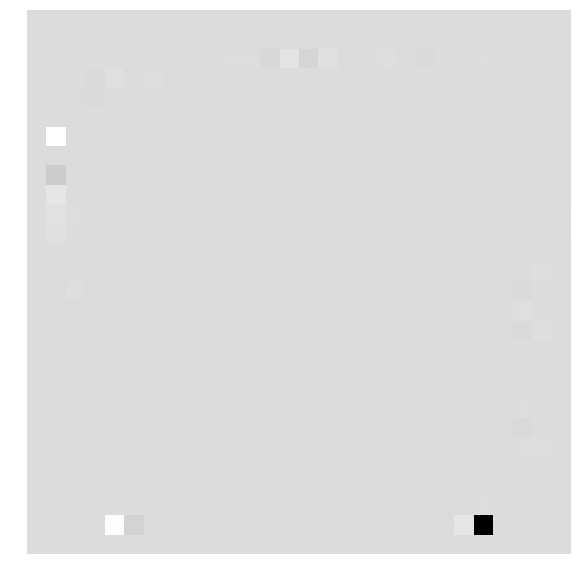

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(-W[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.axis("off")
plt.show()

('X_std_lda.shape:', (11552, 1))
('lda.coef_:', (1, 784))


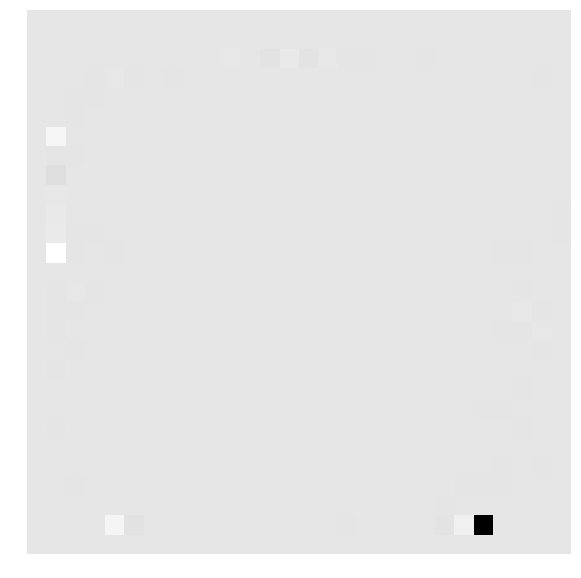

In [19]:

#compare with provided LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_std_lda = lda.fit_transform(X, y)
print('X_std_lda.shape:', X_std_lda.shape)
print('lda.coef_:', lda.coef_.shape)

plt.figure(figsize=(10,10))
plt.imshow(lda.coef_[0].reshape((28, 28)).T, cmap='gray', interpolation='nearest')
plt.axis("off")
plt.show()
# myLDA is same with LA.lda, but result is wierd ......



In [20]:
W[0].shape

(1, 784)

In [21]:
lda.coef_.shape

(1, 784)

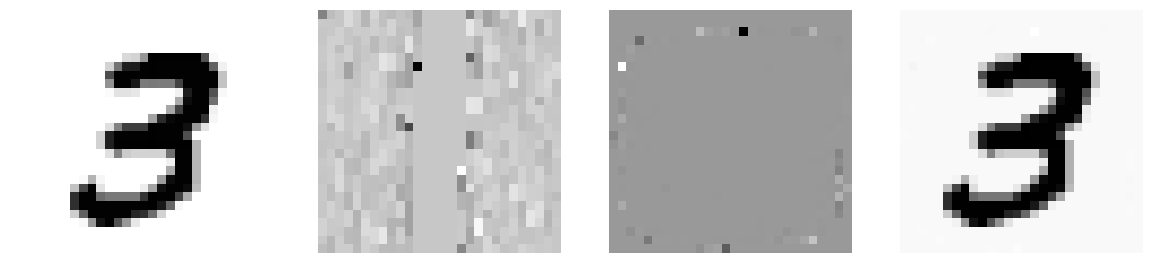

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,15))
orig_X = X_3_5.ix[X_3_5.index[0]]
eig_vecs_sorted = np.matrix(eig_vecs_sorted)

ax1.imshow(orig_X.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax1.set_axis_off()

projection = orig_X.reshape(1, -1) * eig_vecs_sorted.T
ax2.imshow(projection.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax2.set_axis_off()

reconstruction = projection * eig_vecs_sorted
ax3.imshow(reconstruction.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax3.set_axis_off()

diff = normalize(np.array(orig_X, dtype=pd.Series) - reconstruction, axis=1).ravel()
ax4.imshow(diff.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax4.set_axis_off(); plt.show();

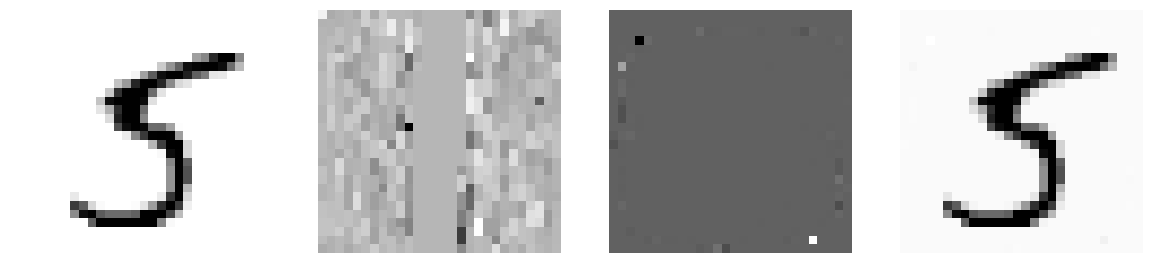

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,15))
orig_X = X_3_5.ix[X_3_5.index[-1]]
eig_vecs_sorted = np.matrix(eig_vecs_sorted)

ax1.imshow(orig_X.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax1.set_axis_off()

projection = orig_X.reshape(1, -1) * eig_vecs_sorted.T
ax2.imshow(projection.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax2.set_axis_off()

reconstruction = projection * eig_vecs_sorted
ax3.imshow(reconstruction.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax3.set_axis_off()

diff = normalize(np.array(orig_X, dtype=pd.Series) - reconstruction, axis=1).ravel()
ax4.imshow(diff.reshape((28, 28)).T, cmap='gray_r', interpolation='nearest'); ax4.set_axis_off(); plt.show();

In [20]:
# projection
pred = X_train.dot(W[0].T)
pred[pred > 0] = Cs[0]
pred[pred <= 0] = Cs[1]

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_train,pred)
print "confusion_matrix for training set"
print accuracy

confusion_matrix for training set
[[6079   52]
 [ 849 4572]]


In [21]:
# projection
pred = X_test.dot(W[0].T)
pred[pred > 0] = Cs[0]
pred[pred <= 0] = Cs[1]

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_test,pred)
print "confusion_matrix for test set"
print accuracy

confusion_matrix for test set
[[999  11]
 [167 725]]


In [22]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[999  11]
 [167 725]]
Normalized confusion matrix
[[ 0.98910891  0.01089109]
 [ 0.18721973  0.81278027]]


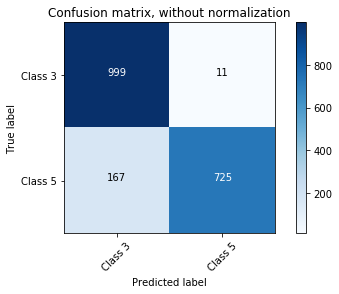

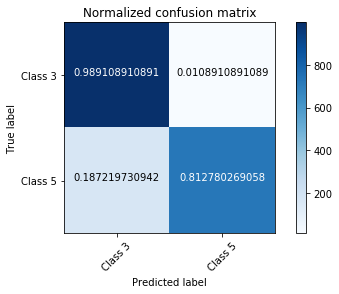

In [23]:
#labels = ['Class 0', 'Class 1']
labels = ['Class 3', 'Class 5']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [24]:
# LDA on test set

In [25]:
#Naive Bayes
from sklearn.cross_validation import train_test_split
import math
import numpy as np

label_dict = {3: 'Class 3', 5: 'Class 5'}
np.set_printoptions(precision=4)
#X_train, X_test, y_train, y_test = train_test_split(X_0_1.as_matrix(), y_0_1.as_matrix(), test_size=0.5, random_state=39)
#class 0 cl = 0
X_train = X_3_5
y_train = y_3_5
X_test = X_3_5t
y_test = y_3_5t
mean_vectors = []
#compute mean
for cl in Cs:
    mean_vectors.append(np.mean(X_train[y_train.values == cl], axis=0))
variance = np.var(X_train, axis = 0)


In [26]:
w0 = math.log(1)
w1_vectors = []
valid_dims = []
for i in range(784):
    if variance[i] > 0.1:
        valid_dims.append(i)
        w0 = w0 + (-mean_vectors[0][i] ** 2 + mean_vectors[1][i] ** 2) / (2 * variance[i])
        w1_vectors.append((mean_vectors[0][i] - mean_vectors[1][i]) / variance[i])

In [27]:
w1_vectors = np.array(w1_vectors)

In [28]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

In [29]:
len(valid_dims)

248

In [30]:
pred = []
for i in range(X_train.shape[0]):
    xi = X_train[i]
    x_temp = xi[valid_dims]
    temp = math.exp(w0 + np.dot(x_temp.T, w1_vectors))
    pred.append(1/(1+temp))

In [31]:
pred = [Cs[1] if i >= 0.5 else Cs[0] for i in pred]

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_train,pred)
print "confusion_matrix for training set"
print accuracy

confusion_matrix for training set
[[5328  803]
 [ 774 4647]]


In [32]:
pred = []
for i in range(X_test.shape[0]):
    xi = X_test[i]
    x_temp = xi[valid_dims]
    temp = math.exp(w0 + np.dot(x_temp.T, w1_vectors))
    pred.append(1/(1+temp))

In [33]:
pred = [Cs[1] if i >= 0.5 else Cs[0] for i in pred]

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_test, pred)
print "confusion_matrix for training set"
print accuracy

confusion_matrix for training set
[[900 110]
 [122 770]]


Confusion matrix, without normalization
[[900 110]
 [122 770]]
Normalized confusion matrix
[[ 0.8911  0.1089]
 [ 0.1368  0.8632]]


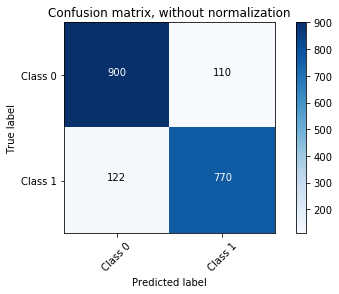

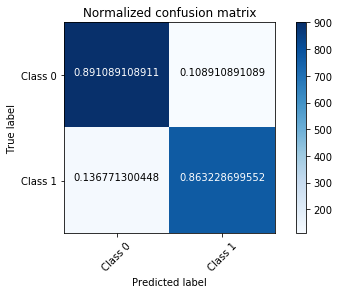

In [34]:
labels = ['Class 0', 'Class 1']
#labels = ['Class 3', 'Class 5']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(accuracy, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()